In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# Load Iris dataset
iris = load_iris()
data = sns.load_dataset('iris')

# Set style
sns.set(style="white", palette="muted")

# Create a pair plot with KDE
sns.pairplot(data, hue="species", height=2.5, diag_kind="kde")

# Show the plot
plt.show()


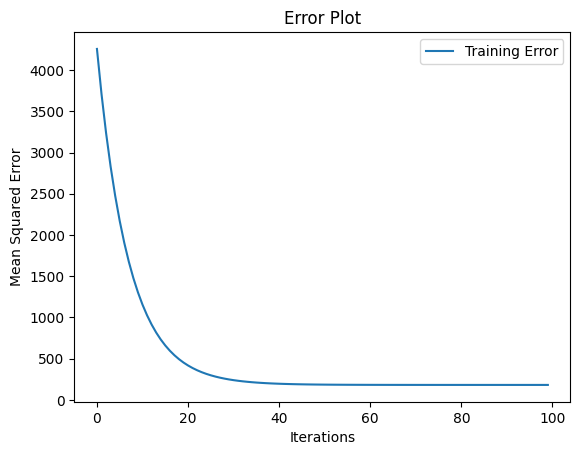

Mean squared error: 491.80941994778624


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

    
X, y = make_regression(n_samples=100, n_features=3, noise=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
n_samples, n_features = np.shape(X)
model = LinearRegression(n_iterations=100)
model.fit(X_train, y_train)

# Training error plot
n = len(model.training_errors)
training, = plt.plot(range(n), model.training_errors, label="Training Error")
plt.legend(handles=[training])
plt.title("Error Plot")
plt.ylabel('Mean Squared Error')
plt.xlabel('Iterations')
plt.show()
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print ("Mean squared error: %s" % (mse))
y_pred_line = model.predict(X)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


,sepal_length,sepal_width,petal_length,petal_width,species
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor
53,5.5,2.3,4.0,1.3,versicolor
54,6.5,2.8,4.6,1.5,versicolor
55,5.7,2.8,4.5,1.3,versicolor
56,6.3,3.3,4.7,1.6,versicolor
57,4.9,2.4,3.3,1.0,versicolor
58,6.6,2.9,4.6,1.3,versicolor
59,5.2,2.7,3.9,1.4,versicolor


,sepal_length,sepal_width,petal_length,petal_width,species
100,6.3,3.3,6.0,2.5,virginica
101,5.8,2.7,5.1,1.9,virginica
102,7.1,3.0,5.9,2.1,virginica
103,6.3,2.9,5.6,1.8,virginica
104,6.5,3.0,5.8,2.2,virginica
105,7.6,3.0,6.6,2.1,virginica
106,4.9,2.5,4.5,1.7,virginica
107,7.3,2.9,6.3,1.8,virginica
108,6.7,2.5,5.8,1.8,virginica
109,7.2,3.6,6.1,2.5,virginica


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


,sepal_length,sepal_width,petal_length,petal_width,species
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor
53,5.5,2.3,4.0,1.3,versicolor
54,6.5,2.8,4.6,1.5,versicolor
55,5.7,2.8,4.5,1.3,versicolor
56,6.3,3.3,4.7,1.6,versicolor
57,4.9,2.4,3.3,1.0,versicolor
58,6.6,2.9,4.6,1.3,versicolor
59,5.2,2.7,3.9,1.4,versicolor


,sepal_length,sepal_width,petal_length,petal_width,species
100,6.3,3.3,6.0,2.5,virginica
101,5.8,2.7,5.1,1.9,virginica
102,7.1,3.0,5.9,2.1,virginica
103,6.3,2.9,5.6,1.8,virginica
104,6.5,3.0,5.8,2.2,virginica
105,7.6,3.0,6.6,2.1,virginica
106,4.9,2.5,4.5,1.7,virginica
107,7.3,2.9,6.3,1.8,virginica
108,6.7,2.5,5.8,1.8,virginica
109,7.2,3.6,6.1,2.5,virginica


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


,sepal_length,sepal_width,petal_length,petal_width,species
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor
53,5.5,2.3,4.0,1.3,versicolor
54,6.5,2.8,4.6,1.5,versicolor
55,5.7,2.8,4.5,1.3,versicolor
56,6.3,3.3,4.7,1.6,versicolor
57,4.9,2.4,3.3,1.0,versicolor
58,6.6,2.9,4.6,1.3,versicolor
59,5.2,2.7,3.9,1.4,versicolor


,sepal_length,sepal_width,petal_length,petal_width,species
100,6.3,3.3,6.0,2.5,virginica
101,5.8,2.7,5.1,1.9,virginica
102,7.1,3.0,5.9,2.1,virginica
103,6.3,2.9,5.6,1.8,virginica
104,6.5,3.0,5.8,2.2,virginica
105,7.6,3.0,6.6,2.1,virginica
106,4.9,2.5,4.5,1.7,virginica
107,7.3,2.9,6.3,1.8,virginica
108,6.7,2.5,5.8,1.8,virginica
109,7.2,3.6,6.1,2.5,virginica


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


,sepal_length,sepal_width,petal_length,petal_width,species
50,7.0,3.2,4.7,1.4,versicolor
51,6.4,3.2,4.5,1.5,versicolor
52,6.9,3.1,4.9,1.5,versicolor
53,5.5,2.3,4.0,1.3,versicolor
54,6.5,2.8,4.6,1.5,versicolor
55,5.7,2.8,4.5,1.3,versicolor
56,6.3,3.3,4.7,1.6,versicolor
57,4.9,2.4,3.3,1.0,versicolor
58,6.6,2.9,4.6,1.3,versicolor
59,5.2,2.7,3.9,1.4,versicolor


,sepal_length,sepal_width,petal_length,petal_width,species
100,6.3,3.3,6.0,2.5,virginica
101,5.8,2.7,5.1,1.9,virginica
102,7.1,3.0,5.9,2.1,virginica
103,6.3,2.9,5.6,1.8,virginica
104,6.5,3.0,5.8,2.2,virginica
105,7.6,3.0,6.6,2.1,virginica
106,4.9,2.5,4.5,1.7,virginica
107,7.3,2.9,6.3,1.8,virginica
108,6.7,2.5,5.8,1.8,virginica
109,7.2,3.6,6.1,2.5,virginica


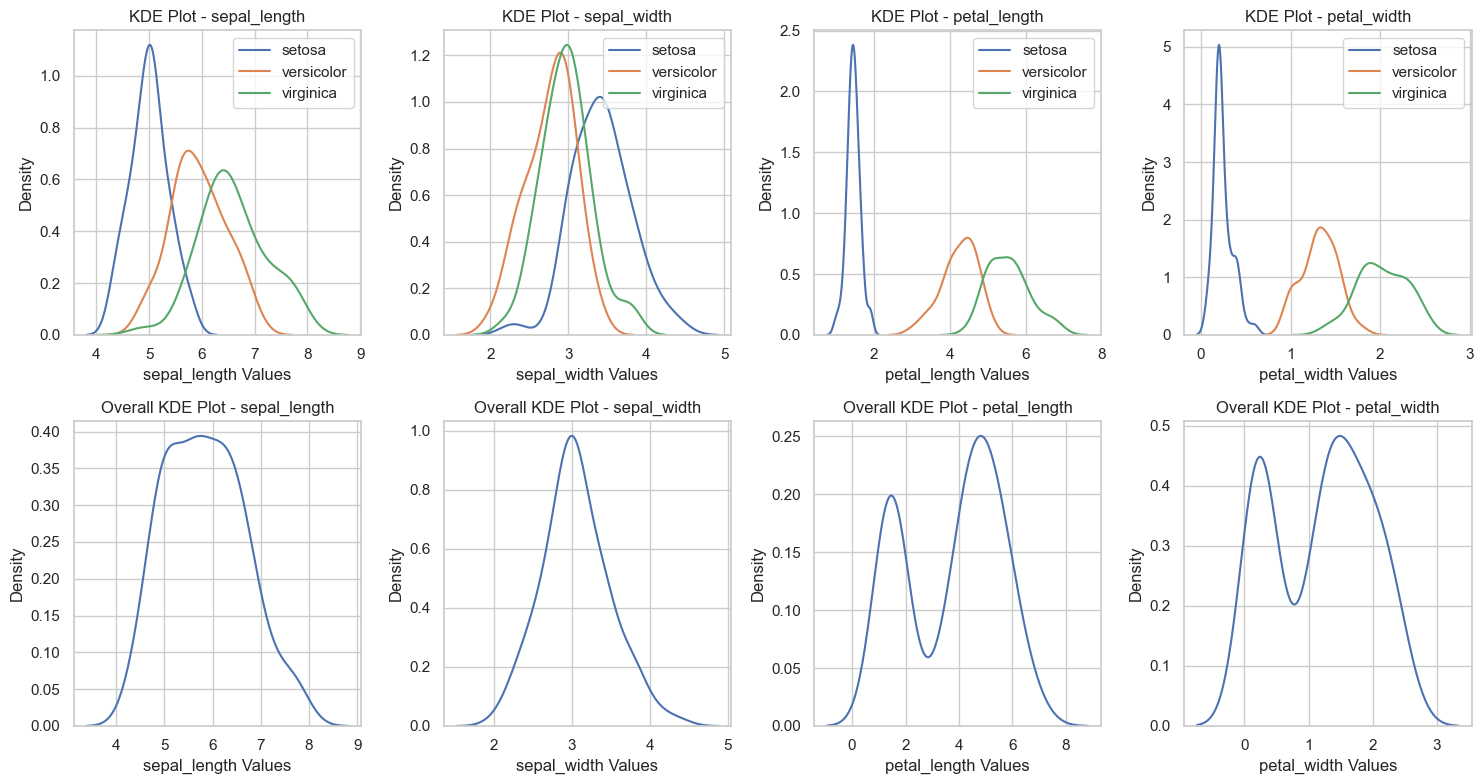

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# Load Iris dataset
iris = load_iris()
data = sns.load_dataset('iris')

# Set style
sns.set(style="whitegrid")

# Create separate KDE plots for each feature with and without subgrouping by species
features = data.columns[:-1]  # Exclude the 'species' column
num_features = len(features)

fig, axes = plt.subplots(nrows=2, ncols=num_features, figsize=(15, 8))

# First row: KDE plots for each feature grouped by species
for i, feature in enumerate(features):
    for species in data['species'].unique():
        subset = data[data['species'] == species]
        display(subset)
        sns.kdeplot(subset[feature], ax=axes[0, i], label=species)

    axes[0, i].set_title(f'KDE Plot - {feature}')
    axes[0, i].set_xlabel(f'{feature} Values')
    axes[0, i].set_ylabel('Density')
    axes[0, i].legend()

# Second row: Overall KDE plots for each feature without subgrouping by species
for i, feature in enumerate(features):
    sns.kdeplot(data[feature], ax=axes[1, i])
    axes[1, i].set_title(f'Overall KDE Plot - {feature}')
    axes[1, i].set_xlabel(f'{feature} Values')
    axes[1, i].set_ylabel('Density')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


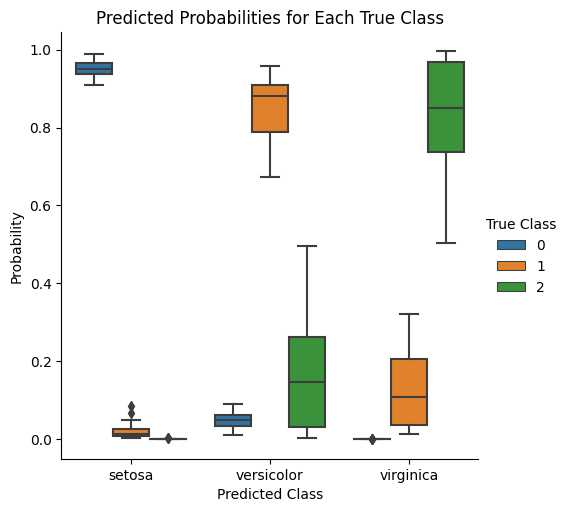

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Load Iris dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Get predicted probabilities for each class
probs = log_reg.predict_proba(X_test)

# Create a DataFrame for probabilities
probs_df = pd.DataFrame(probs, columns=iris.target_names)

# Separate probabilities into three subsets based on true class labels
subset_probs = []
for class_label in range(3):
    subset_probs.append(probs_df[y_test == class_label])

# Combine all subsets into one DataFrame
combined_df = pd.concat(subset_probs)

# Add a column for the true class labels
true_labels = []
for class_label, subset in enumerate(subset_probs):
    true_labels.extend([class_label] * len(subset))

combined_df['True Class'] = true_labels

# Melt the DataFrame for plotting
melted_df = pd.melt(combined_df, id_vars=['True Class'], var_name='Predicted Class', value_name='Probability')

# Create a box plot with seaborn's catplot
sns.catplot(x='Predicted Class', y='Probability', hue='True Class', kind='box', data=melted_df)
plt.title('Predicted Probabilities for Each True Class')
plt.show()


In [7]:
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the priors (prior probabilities of the classes)
# For demonstration purposes, let's set equal priors for all classes
# You can adjust these priors based on your domain knowledge or any prior information you have
class_priors = [0.3, 0.3, 0.4]  # Assuming equal priors for all classes

# Initialize and fit the LDA model with priors
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lda.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 1.0


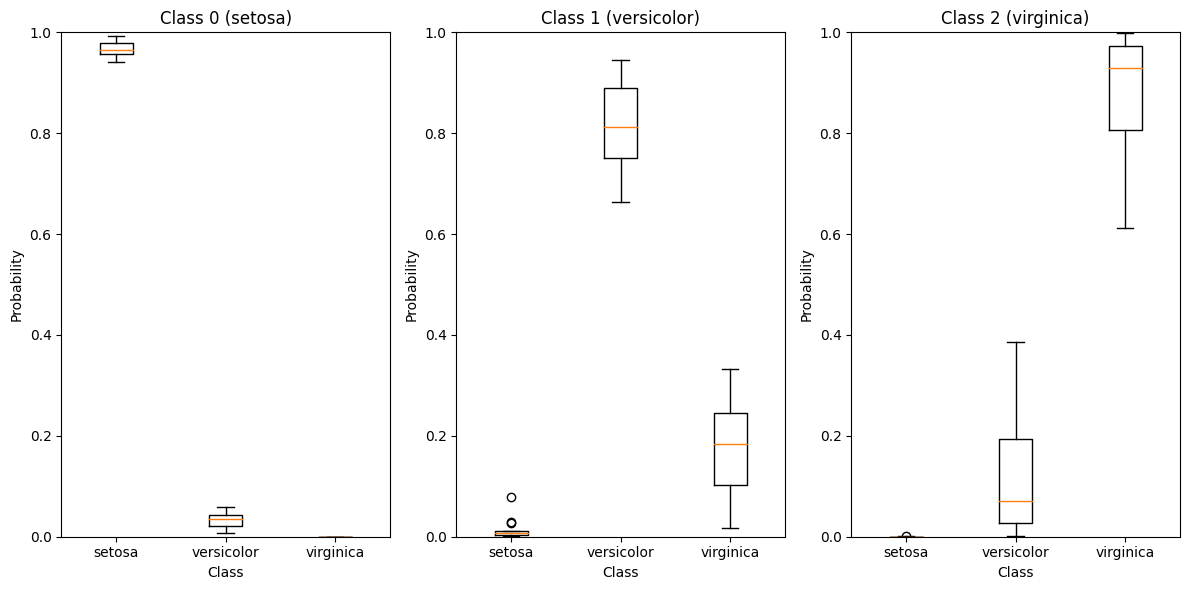

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities for the test set
probabilities = model.predict_proba(X_test)

# Convert true labels to binary form
y_test_binary = label_binarize(y_test, classes=[0, 1, 2])

# Plot box plots for each class separately
plt.figure(figsize=(12, 6))

for i in range(3):  # Iterate over each class
    plt.subplot(1, 3, i + 1)
    plt.boxplot(probabilities[y_test == i], labels=iris.target_names)
    plt.title(f"Class {i} ({iris.target_names[i]})")
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.ylim(0, 1)  # Set y-axis limit to 1

plt.tight_layout()
plt.show()


array([[3.78598857e-03, 8.27163425e-01, 1.69050587e-01],
       [9.46759942e-01, 5.32398576e-02, 2.00228370e-07],
       [8.73360188e-09, 1.55786699e-03, 9.98442124e-01],
       [6.43555904e-03, 7.92090715e-01, 2.01473726e-01],
       [1.44167343e-03, 7.74260761e-01, 2.24297566e-01],
       [9.55797854e-01, 4.42019691e-02, 1.77067966e-07],
       [7.76326291e-02, 9.08053248e-01, 1.43141231e-02],
       [1.61507381e-04, 1.55712044e-01, 8.44126449e-01],
       [2.20837508e-03, 7.62733010e-01, 2.35058615e-01],
       [2.83250238e-02, 9.45772471e-01, 2.59025047e-02],
       [4.39851100e-04, 2.43324013e-01, 7.56236136e-01],
       [9.68323436e-01, 3.16764859e-02, 7.81820869e-08],
       [9.72954548e-01, 2.70454185e-02, 3.33811329e-08],
       [9.62114804e-01, 3.78850847e-02, 1.11084590e-07],
       [9.79280058e-01, 2.07198771e-02, 6.48295769e-08],
       [4.54350373e-03, 7.12595344e-01, 2.82861152e-01],
       [7.23106253e-06, 2.42186217e-02, 9.75774147e-01],
       [2.73373155e-02, 9.47668

,True Class,Predicted Class,Probability
0,versicolor,setosa,3.785989e-03
1,setosa,setosa,9.467599e-01
2,virginica,setosa,8.733602e-09
3,versicolor,setosa,6.435559e-03
4,versicolor,setosa,1.441673e-03
...,...,...,...
85,virginica,virginica,8.948141e-01
86,virginica,virginica,9.416305e-01
87,virginica,virginica,9.811316e-01
88,setosa,virginica,1.359836e-07


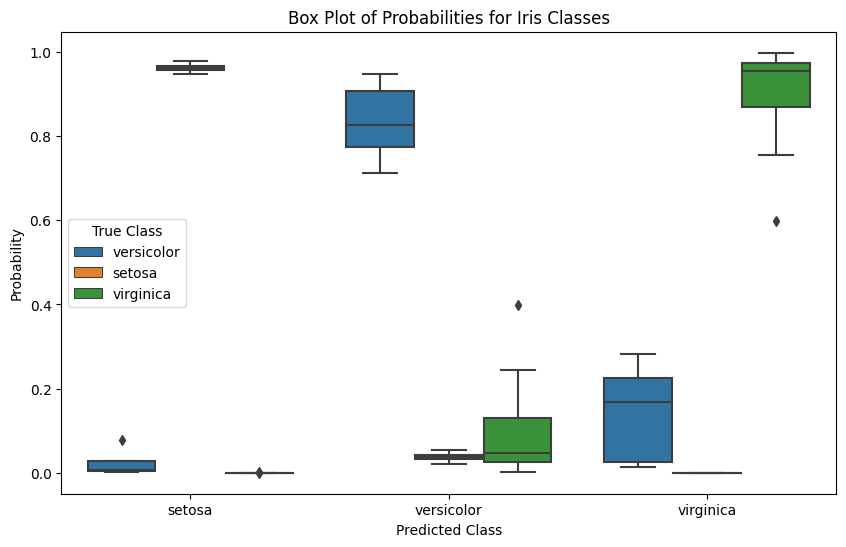

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities for each class
probs = model.predict_proba(X_test)
display(probs)
# Create a DataFrame for plotting
df = pd.DataFrame(probs, columns=iris.target_names)
# Add true class labels to the DataFrame
df['True Class'] = iris.target_names[y_test]

# Melt the DataFrame to make it suitable for seaborn boxplot
df_melted = pd.melt(df, id_vars='True Class', var_name='Predicted Class', value_name='Probability')
display(df_melted)

# Create box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Predicted Class', y='Probability', hue='True Class', data=df_melted)
plt.title('Box Plot of Probabilities for Iris Classes')
plt.xlabel('Predicted Class')
plt.ylabel('Probability')
plt.legend(title='True Class')
plt.show()


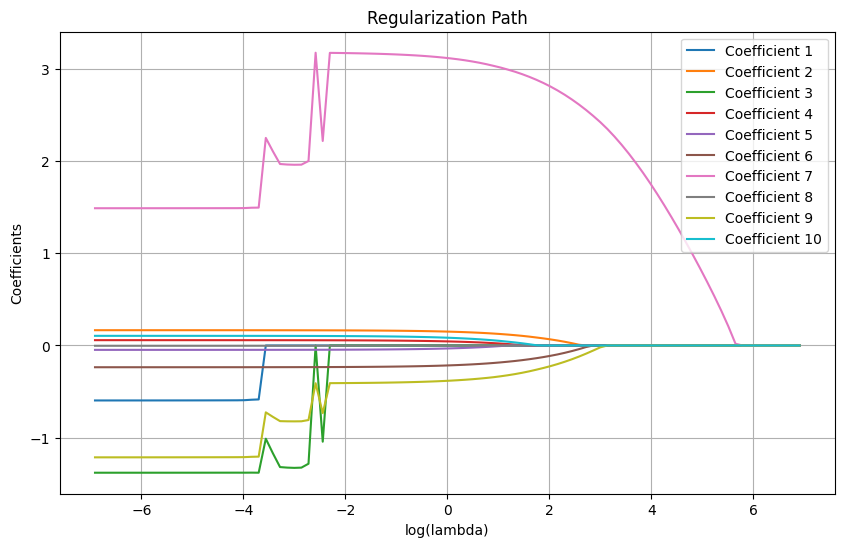

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate some synthetic data
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a range of regularization parameters
alphas = np.logspace(-3, 3, 100)

# Train logistic regression models with different regularization parameters
coefficients = []
for alpha in alphas:
    log_reg = LogisticRegression(penalty='l1', solver='liblinear', C=1/alpha, random_state=42)
    log_reg.fit(X_train_scaled, y_train)
    coefficients.append(log_reg.coef_[0])

# Plot the coefficients as a function of log(lambda)
plt.figure(figsize=(10, 6))
plt.plot(np.log(alphas), coefficients)
plt.xlabel('log(lambda)')
plt.ylabel('Coefficients')
plt.title('Regularization Path')
plt.legend([f'Coefficient {i+1}' for i in range(X.shape[1])])
plt.grid(True)
plt.show()


In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import statsmodels.api as sm

# Load the Iris dataset
iris_sklearn = load_iris()

# Convert the dataset to a DataFrame
iris = pd.DataFrame(data=iris_sklearn.data, columns=iris_sklearn.feature_names)
iris['Species'] = iris_sklearn.target

# Convert the target variable to categorical
iris['Species'] = iris['Species'].astype('category')

# Create dummy variables for the categorical target variable 'Species'
iris = pd.get_dummies(iris, columns=['Species'])

# Define predictor variables
X = iris[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]

# Define target variable
y = iris[['Species_0', 'Species_1', 'Species_2']]

# Fit multinomial logistic regression model
model = sm.MNLogit(y, sm.add_constant(X)).fit()

# Summary of the model
print(model.summary())


Optimization terminated successfully.
         Current function value: nan
         Iterations 26
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  150
Model:                        MNLogit   Df Residuals:                      140
Method:                           MLE   Df Model:                            8
Date:                Wed, 20 Mar 2024   Pseudo R-squ.:                     nan
Time:                        18:55:40   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -164.79
Covariance Type:            nonrobust   LLR p-value:                       nan
      y=Species_1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                    nan        nan        nan        nan         nan         nan
sepal length

C:\Users\versu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\discrete\discrete_model.py:3025: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
C:\Users\versu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\discrete\discrete_model.py:3026: RuntimeWarning: invalid value encountered in divide
  return eXB/eXB.sum(1)[:,None]


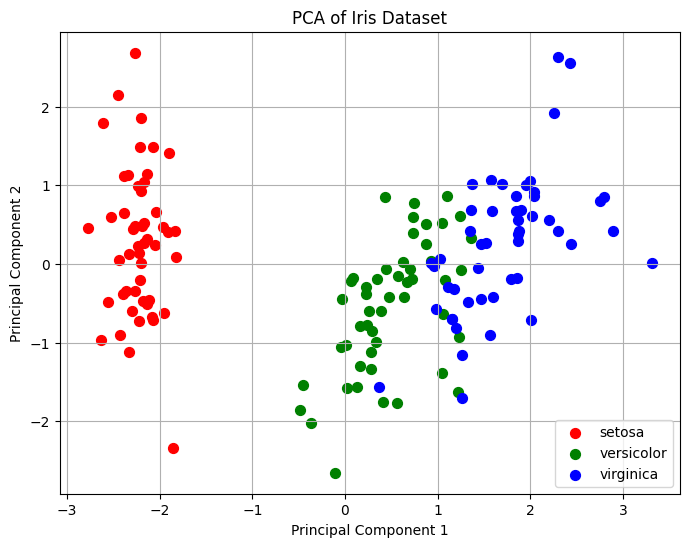

In [5]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
# Create a DataFrame for visualization
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3'])
df_pca['Target'] = y

# Visualize the PCA results
plt.figure(figsize=(8, 6))
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = df_pca['Target'] == target
    plt.scatter(df_pca.loc[indicesToKeep, 'PC1'],
                df_pca.loc[indicesToKeep, 'PC2'],
                c=color,
                s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(iris.target_names)
plt.title('PCA of Iris Dataset')
plt.grid()
plt.show()


In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Load Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Add constant to X
X = sm.add_constant(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit logistic regression model
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Print summary of the model
print(result.summary())

# Confidence intervals for the coefficients
print(result.conf_int())


ValueError: endog must be in the unit interval.

In [1]:
import numpy as np
import matplotlib.pylab as pl

from ot.dr import wda, fda

ModuleNotFoundError: No module named 'ot'

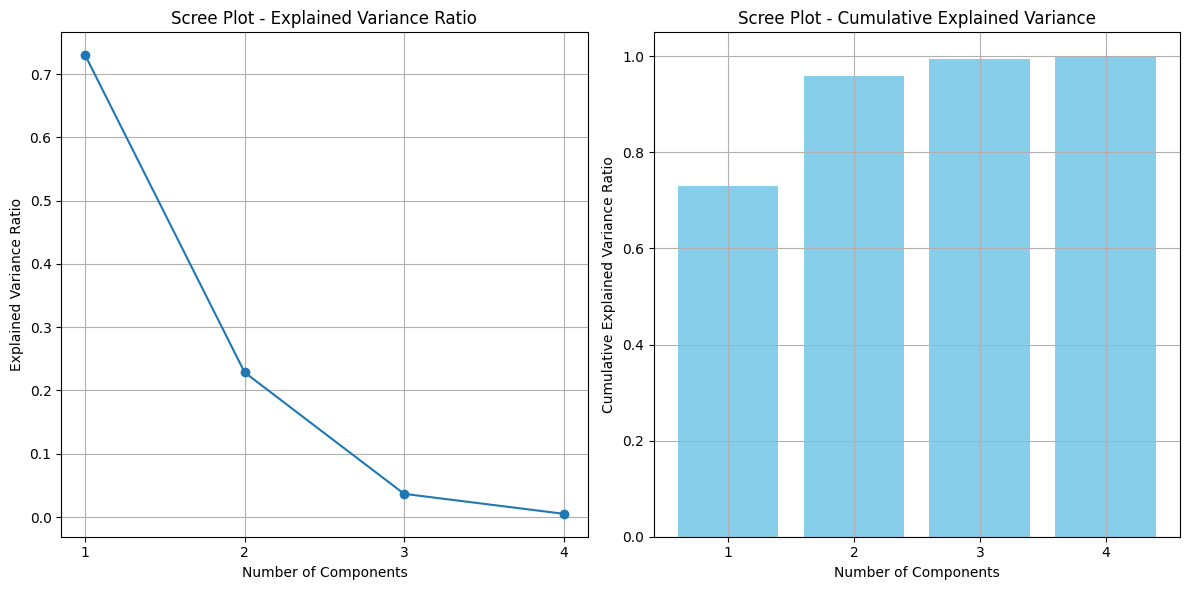

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Scree plot with both line and histogram
plt.figure(figsize=(12, 6))

# Line plot
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, pca.n_components_ + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot - Explained Variance Ratio')
plt.xticks(np.arange(1, pca.n_components_ + 1))
plt.grid(True)

# Histogram
plt.subplot(1, 2, 2)
plt.bar(np.arange(1, pca.n_components_ + 1), np.cumsum(explained_variance_ratio), color='skyblue')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Scree Plot - Cumulative Explained Variance')
plt.xticks(np.arange(1, pca.n_components_ + 1))
plt.grid(True)

plt.tight_layout()
plt.show()


In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and fit the logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = log_reg.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred, target_names=iris.target_names))


              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       1.00      1.00      1.00        13
   virginica       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



[[9, 10], [11, 12]]

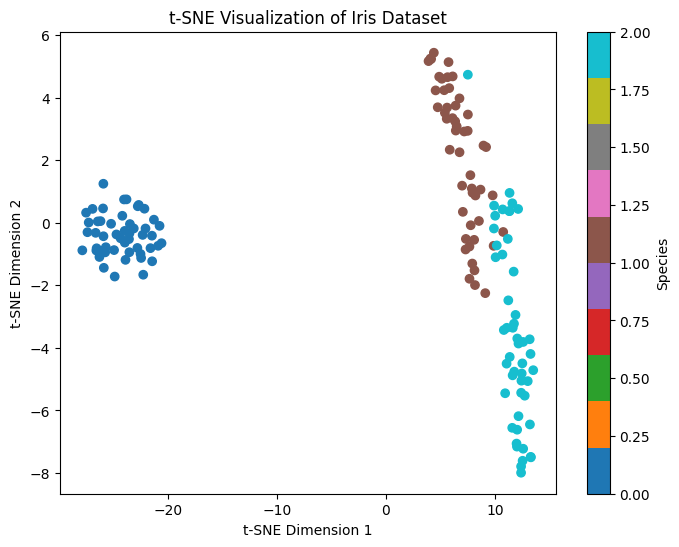

In [16]:

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
nested_array = [[9, 10], [11, 12]]
X_tsne = tsne.fit_transform(X)
display(nested_array)
# Plot the t-SNE visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=plt.cm.tab10)
plt.title('t-SNE Visualization of Iris Dataset')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Species')
plt.show()


In [ ]:
nested_array = [[[1, 2], [3, 4]], [[5, 6], [7, 8]], [[9, 10], [11, 12]]]


In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform( np.array([[9, 10,1], [11, 12,5]]))

ValueError: perplexity must be less than n_samples

In [4]:
from PIL import Image, ImageDraw

# Define image dimensions
width = 200
height = 100

# Create a new image
image = Image.new("RGB", (width, height), color="green")  # Background color

# Define line coordinates
start_x = 20
start_y = height // 2
end_x = width - 20
end_y = start_y

# Draw the line
draw = ImageDraw.Draw(image)
draw.line((start_x, start_y, end_x, end_y), fill="gray", width=3)

# Generate random "noise" for the river path (similar to Matplotlib)
noise_amplitude = 5
noise = np.random.rand(end_x - start_x) * noise_amplitude - noise_amplitude / 2

# Create a list of river path coordinates
river_path = []
for i in range(start_x, end_x):
    river_path.append((i, start_y + noise[i - start_x]))

# Draw a filled polygon for the river (can be adjusted for smoother curves)
draw.polygon(river_path, fill="blue")

# Display the image
image.show()


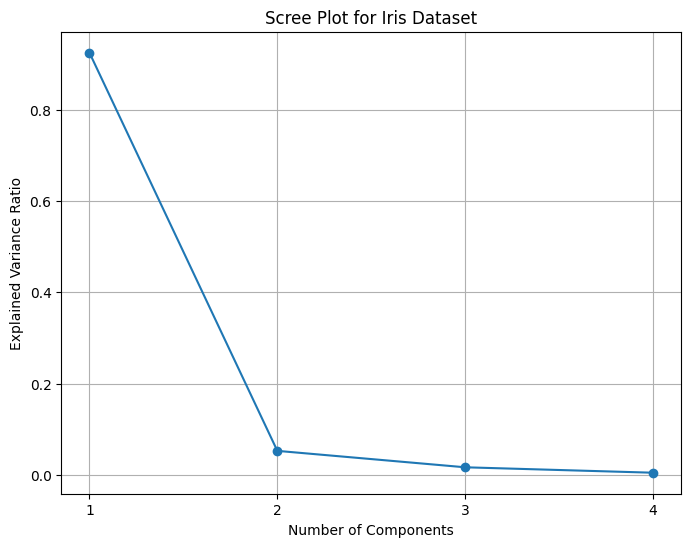

array([[-2.68412563e+00,  3.19397247e-01, -2.79148276e-02,
        -2.26243707e-03],
       [-2.71414169e+00, -1.77001225e-01, -2.10464272e-01,
        -9.90265503e-02],
       [-2.88899057e+00, -1.44949426e-01,  1.79002563e-02,
        -1.99683897e-02],
       [-2.74534286e+00, -3.18298979e-01,  3.15593736e-02,
         7.55758166e-02],
       [-2.72871654e+00,  3.26754513e-01,  9.00792406e-02,
         6.12585926e-02],
       [-2.28085963e+00,  7.41330449e-01,  1.68677658e-01,
         2.42008576e-02],
       [-2.82053775e+00, -8.94613845e-02,  2.57892158e-01,
         4.81431065e-02],
       [-2.62614497e+00,  1.63384960e-01, -2.18793179e-02,
         4.52978706e-02],
       [-2.88638273e+00, -5.78311754e-01,  2.07595703e-02,
         2.67447358e-02],
       [-2.67275580e+00, -1.13774246e-01, -1.97632725e-01,
         5.62954013e-02],
       [-2.50694709e+00,  6.45068899e-01, -7.53180094e-02,
         1.50199245e-02],
       [-2.61275523e+00,  1.47299392e-02,  1.02150260e-01,
      

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Scree plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
plt.title('Scree Plot for Iris Dataset')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(True)
plt.show()
display(X_pca)


In [1]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, f1_score

# Example true labels and predicted labels for multi-class classification
true_labels = [1, 1, 2, 1, 1, 2, 1, 2, 1]
predicted_labels = [1, 2, 1, 1, 1, 2, 1, 2, 1]

# Calculate precision, recall, and support
precision_recall_support = precision_recall_fscore_support(true_labels, predicted_labels,labels=[0,1,2])
class_report = classification_report(true_labels, predicted_labels)
f1_micro = f1_score(true_labels, predicted_labels, average='micro')

print("Precision, Recall, Support for each class:")
for i in range(len(precision_recall_support[0])):
    print(f"Class {i}:")
    print(f"Precision: {precision_recall_support[0][i]}")
    print(f"Recall: {precision_recall_support[1][i]}")
    print(f"f: {precision_recall_support[2][i]}")
    print(f"Support: {precision_recall_support[3][i]}")
    print()

print("Micro-average F1-score:", f1_micro)

print("Classification Report:")
print(class_report)


Precision, Recall, Support for each class:
Class 0:
Precision: 0.0
Recall: 0.0
f: 0.0
Support: 0

Class 1:
Precision: 0.8333333333333334
Recall: 0.8333333333333334
f: 0.8333333333333334
Support: 6

Class 2:
Precision: 0.6666666666666666
Recall: 0.6666666666666666
f: 0.6666666666666666
Support: 3

Micro-average F1-score: 0.7777777777777778
Classification Report:
              precision    recall  f1-score   support

           1       0.83      0.83      0.83         6
           2       0.67      0.67      0.67         3

    accuracy                           0.78         9
   macro avg       0.75      0.75      0.75         9
weighted avg       0.78      0.78      0.78         9



C:\Users\versu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\versu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(50, 1)
(50, 1)


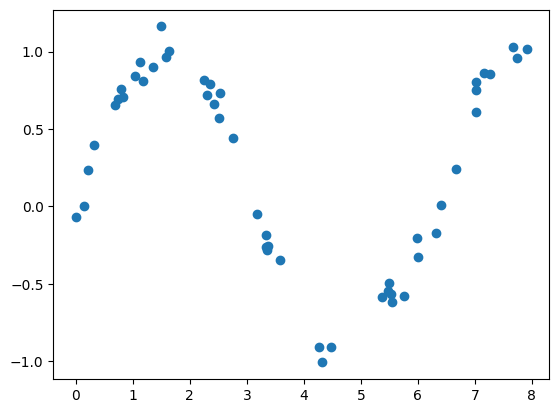

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
rng = np.random.RandomState(1)
x = 8 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

#Create single dimension
x= x[:,np.newaxis]
y= y[:,np.newaxis]

inds = x.ravel().argsort()  # Sort x values and get index    
x = x.ravel()[inds].reshape(-1,1)
y = y[inds] #Sort y according to x sorted index

print(x.shape)
print(y.shape)

#Plot
plt.scatter(x,y)

(50, 4)

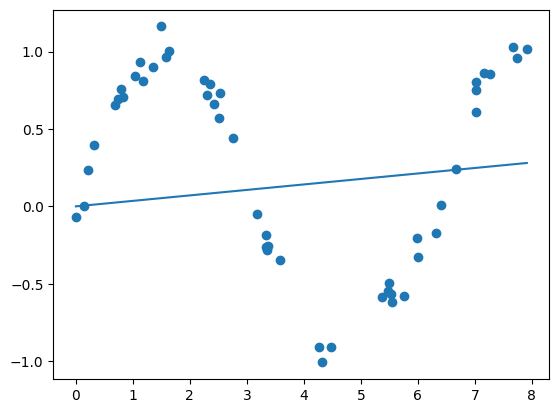

In [2]:
import statsmodels.api as sm

model = sm.OLS(y, x).fit()
ypred = model.predict(x) 

plt.scatter(x,y)
plt.plot(x,ypred)
from sklearn.preprocessing import PolynomialFeatures
polynomial_features= PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(x)
xp.shape


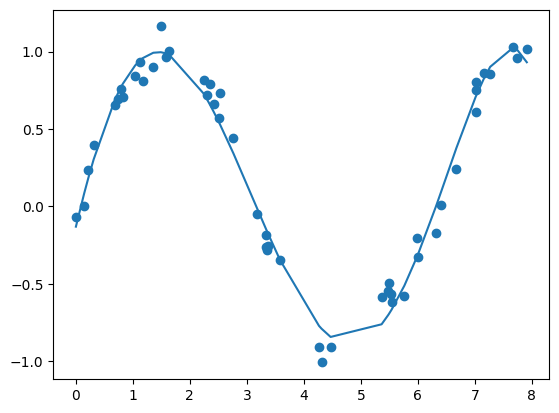

In [3]:
from sklearn.preprocessing import PolynomialFeatures
polynomial_features= PolynomialFeatures(degree=5)
xp = polynomial_features.fit_transform(x)
xp.shape

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

plt.scatter(x,y)
plt.plot(x,ypred)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Binarize the labels for each class separately
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Get predicted probabilities for each class
y_probs = classifier.predict_proba(X_test)

# Calculate ROC curve and AUC for each class
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label='ROC curve (class {0}) (area = {1:0.2f})'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Iris Dataset (One-vs-All)')
plt.legend(loc="lower right")
plt.show()


ValueError: y should be a 1d array, got an array of shape (120, 3) instead.

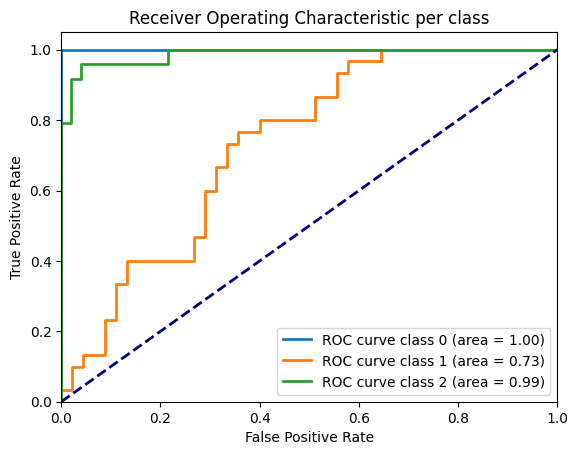

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Train a classifier for each class
classifiers = []
for i in range(y.shape[1]):
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train[:, i])
    classifiers.append(classifier)

# Compute ROC curve and ROC area for each class
plt.figure()
lw = 2
for i, classifier in enumerate(classifiers):
    y_score = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test[:, i], y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, label='ROC curve class %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic per class')
plt.legend(loc="lower right")
plt.show()


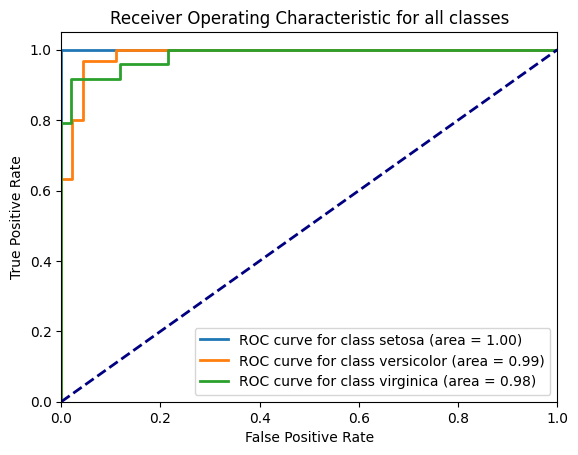

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Train a classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Compute predicted probabilities
y_probs = classifier.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
plt.figure()
lw = 2
for i in range(len(iris.target_names)):
    fpr, tpr, _ = roc_curve(y_test == i, y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, label='ROC curve for class %s (area = %0.2f)' % (iris.target_names[i], roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for all classes')
plt.legend(loc="lower right")
plt.show()


In [24]:
# Load modules and data
import numpy as np

import statsmodels.api as sm
spector_data = sm.datasets.spector.load()

spector_data.exog = sm.add_constant(spector_data.exog, prepend=False)

# Fit and summarize OLS model
mod = sm.OLS(spector_data.endog, spector_data.exog)

res = mod.fit()

import numpy as np
import statsmodels.api as sm
import json

# Load data
spector_data = sm.datasets.spector.load()

# Add constant to exogenous variables
spector_data.exog = sm.add_constant(spector_data.exog, prepend=False)

# Fit OLS model
mod = sm.OLS(spector_data.endog, spector_data.exog)
results = mod.fit_regularized(method='elastic_net', alpha=0.5, L1_wt=1.0, refit=True)

display(results.predict(spector_data.exog))
display(results.summary())



0     0.326361
1     0.358997
2     0.391633
3     0.195817
4     0.342679
5     0.277407
6     0.277407
7     0.342679
8     0.407951
9     0.473223
10    0.326361
11    0.375315
12    0.375315
13    0.407951
14    0.424269
15    0.310043
16    0.407951
17    0.310043
18    0.375315
19    0.407951
20    0.358997
21    0.456905
22    0.228453
23    0.424269
24    0.391633
25    0.440587
26    0.277407
27    0.391633
28    0.342679
29    0.375315
30    0.342679
31    0.310043
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  GRADE   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     2.037
Date:                Tue, 14 May 2024   Prob (F-statistic):              0.163
Time:                        22:48:18   Log-Likelihood:                -20.563
No. Observations:                  32   AIC:                             45.13
Df Residuals:                      31   BIC:                             48.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GPA                 0          0        nan        nan           0           0
TUCE           0.0163      0.004      4.398      0.000       0.009       0.024
PSI                 0          0        nan        nan           0           0
const               0          0        nan        nan           0           0
==============================================================================
Omnibus:                       22.139   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.271
Skew:                           0.642   Prob(JB):                       0.0717
Kurtosis:                       1.481   Cond. No.                         176.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# Load modules and data
import numpy as np

import statsmodels.api as sm
spector_data = sm.datasets.spector.load()

spector_data.exog = sm.add_constant(spector_data.exog, prepend=False)

# Fit and summarize OLS model
mod = sm.OLS(spector_data.endog, spector_data.exog)

res = mod.fit()

import numpy as np
import statsmodels.api as sm
import json

# Load data
spector_data = sm.datasets.spector.load()

# Add constant to exogenous variables
spector_data.exog = sm.add_constant(spector_data.exog, prepend=False)

# Fit OLS model
mod = sm.OLS(spector_data.endog, spector_data.exog)
res = mod.fit_regularized(method='elastic_net', alpha=0.5, L1_wt=1.0, refit=True)
        # Extract summary information
summary_dict = {
            "params": res.params.tolist(),
            "bse": res.bse.tolist(),
            "tvalues": res.tvalues.tolist(),
            "pvalues": res.pvalues.tolist(),
            "rsquared": res.rsquared,
            "rsquared_adj": res.rsquared_adj,
            "fvalue": res.fvalue,
            "f_pvalue": res.f_pvalue,
            "aic": res.aic,
            "bic": res.bic
        }

display(results.summary())

display(summary_dict)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  GRADE   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     2.037
Date:                Wed, 15 May 2024   Prob (F-statistic):              0.163
Time:                        06:42:20   Log-Likelihood:                -20.563
No. Observations:                  32   AIC:                             45.13
Df Residuals:                      31   BIC:                             48.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GPA                 0          0        nan        nan           0           0
TUCE           0.0163      0.004      4.398      0.000       0.009       0.024
PSI                 0          0        nan        nan           0           0
const               0          0        nan        nan           0           0
==============================================================================
Omnibus:                       22.139   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.271
Skew:                           0.642   Prob(JB):                       0.0717
Kurtosis:                       1.481   Cond. No.                         176.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

{'params': [0.0, 0.01631804435483871, 0.0, 0.0],
 'bse': [0.0, 0.0037103420556697745, 0.0, 0.0],
 'tvalues': [nan, 4.397989217706519, nan, nan],
 'pvalues': [nan, 0.00011953945874422716, nan, nan],
 'rsquared': 0.06166212819438632,
 'rsquared_adj': 0.06166212819438632,
 'fvalue': 2.037140385634959,
 'f_pvalue': 0.16349408279169242,
 'aic': 45.1256889914019,
 'bic': 48.05716079700135}

In [36]:
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score (micro and macro)
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
print("F1 Score (Micro):", f1_micro)
print("F1 Score (Macro):", f1_macro)

# Generate and print classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)


Accuracy: 1.0
F1 Score (Micro): [1. 1. 1.]
F1 Score (Macro): 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



C:\Users\versu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


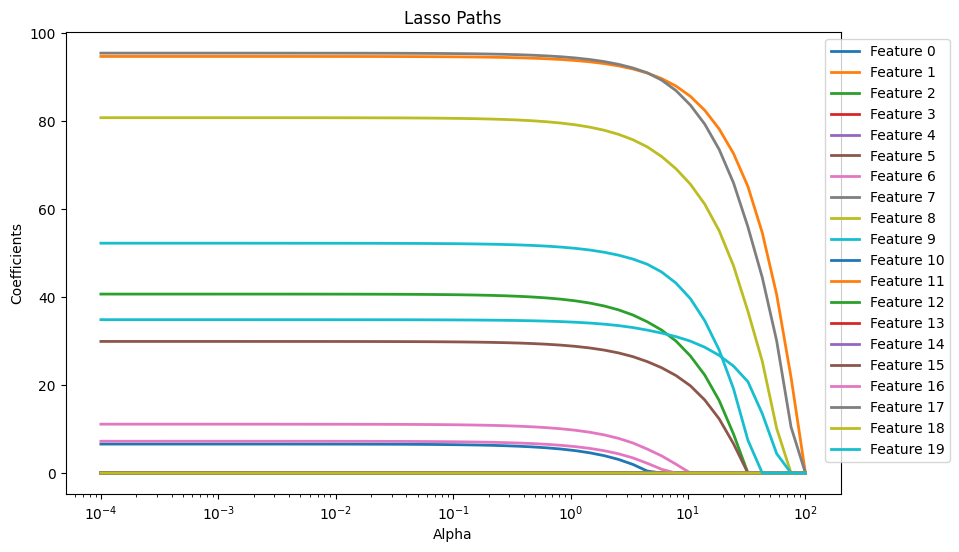

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
from sklearn.datasets import make_regression

# Create a synthetic dataset
X, y = make_regression(n_samples=100, n_features=20, noise=0.1, random_state=42)

# Compute the paths for Lasso regularization with various alpha values
alphas, coefs, _ = lasso_path(X, y, alphas=np.logspace(-4, 2, 50))

# Plot the coefficient paths
plt.figure(figsize=(10, 6))
for coef in coefs:
    plt.plot(alphas, coef, lw=2)

plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Paths')
plt.axis('tight')
plt.legend([f'Feature {i}' for i in range(X.shape[1])], loc='upper right', bbox_to_anchor=(1.15, 1.0))
plt.show()


In [20]:
import statsmodels.api as sm
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the Iris dataset
iris = load_iris()

# Create a DataFrame from the dataset
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

# Add target variable to DataFrame
iris_df['species'] = iris.target

# Map target names to numerical values
label_encoder = LabelEncoder()
iris_df['species'] = label_encoder.fit_transform(iris.target_names[iris.target])

# Split data into independent variables (X) and dependent variable (y)
X = iris_df.iloc[:, :-1]  # Features
y = iris_df['species']     # Target variable

# Add intercept term to independent variables
X = sm.add_constant(X)

# Fit multinomial logistic regression model
glm_model = sm.GLM(y, X, family=sm.families.Binomial())
results = glm_model.fit()

# Access the summary of the fitted model
display(results.summary())


C:\Users\versu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\versu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\versu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warning

'Class: setosa'

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  150
Model:                            GLM   Df Residuals:                      145
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.6475e-09
Date:                Tue, 21 May 2024   Deviance:                   3.2949e-09
Time:                        13:11:29   Pearson chi2:                 1.65e-09
No. Iterations:                    25   Pseudo R-squ. (CS):             0.7200
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -16.9451   4.57e+05  -3.71e-05      1.000   -8.96e+05    8.96e+05
sepal length (cm)    11.7591    1.3e+05   9.01e-05      1.000   -2.56e+05    2.56e+05
sepal width (cm)      7.8413   5.94e+04      0.000      1.000   -1.16e+05    1.16e+05
petal length (cm)   -20.0877   1.08e+05     -0.000      1.000   -2.11e+05    2.11e+05
petal width (cm)    -21.6080   1.54e+05     -0.000      1.000   -3.02e+05    3.02e+05
=====================================================================================
"""

'Class: versicolor'

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  150
Model:                            GLM   Df Residuals:                      145
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -72.535
Date:                Tue, 21 May 2024   Deviance:                       145.07
Time:                        13:11:29   Pearson chi2:                     134.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2635
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.3785      2.499      2.952      0.003       2.480      12.277
sepal length (cm)    -0.2454      0.650     -0.378      0.706      -1.518       1.028
sepal width (cm)     -2.7966      0.784     -3.569      0.000      -4.332      -1.261
petal length (cm)     1.3136      0.684      1.921      0.055      -0.027       2.654
petal width (cm)     -2.7783      1.173     -2.368      0.018      -5.078      -0.479
=====================================================================================
"""

'Class: virginica'

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  150
Model:                            GLM   Df Residuals:                      145
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5.9493
Date:                Tue, 21 May 2024   Deviance:                       11.899
Time:                        13:11:29   Pearson chi2:                     13.2
No. Iterations:                    12   Pseudo R-squ. (CS):             0.6969
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -42.6378     25.708     -1.659      0.097     -93.024       7.748
sepal length (cm)    -2.4652      2.394     -1.030      0.303      -7.158       2.228
sepal width (cm)     -6.6809      4.480     -1.491      0.136     -15.461       2.099
petal length (cm)     9.4294      4.737      1.990      0.047       0.145      18.714
petal width (cm)     18.2861      9.743      1.877      0.061      -0.809      37.381
=====================================================================================
"""

In [27]:
import statsmodels.api as sm
from sklearn.datasets import load_iris
import pandas as pd

# Load Iris dataset
iris = load_iris()

# Convert Iris dataset into a DataFrame
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target

# Rename target variable values to species names
iris_df['species'] = iris_df['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Define independent variables (features)
X = iris_df[iris.feature_names]

# Define dependent variable
y = iris_df['species']

# Add constant term to independent variables
X = sm.add_constant(X)

# Fit multinomial logistic regression model
model = sm.MNLogit(y, X)
result = model.fit(method='bfgs')
summary = result.summary()
summary_table = summary.tables[1].data[0:]
# Display summary of the model
display(result.summary())


         Current function value: 0.057112
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


C:\Users\versu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_optimize.py:1360: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
C:\Users\versu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                species   No. Observations:                  150
Model:                        MNLogit   Df Residuals:                      140
Method:                           MLE   Df Model:                            8
Date:                Tue, 21 May 2024   Pseudo R-squ.:                  0.9480
Time:                        13:23:09   Log-Likelihood:                -8.5668
converged:                      False   LL-Null:                       -164.79
Covariance Type:            nonrobust   LLR p-value:                 9.200e-63
=====================================================================================
species=versicolor       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.6444   1550.515      0.001      0.999   -3037.309    3040.597
sepal length (cm)     -1.4959    444.817     -0.003      0.997    -873.321     870.330
sepal width (cm)      -8.0560    282.766     -0.028      0.977    -562.267     546.155
petal length (cm)     11.9301    374.116      0.032      0.975    -721.324     745.184
petal width (cm)       1.7039    759.366      0.002      0.998   -1486.627    1490.035
--------------------------------------------------------------------------------------
species=virginica       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -6.5053   1550.533     -0.004      0.997   -3045.494    3032.483
sepal length (cm)    -8.0348    444.835     -0.018      0.986    -879.896     863.827
sepal width (cm)    -15.8195    282.793     -0.056      0.955    -570.083     538.444
petal length (cm)    22.1797    374.155      0.059      0.953    -711.152     755.511
petal width (cm)     14.0603    759.384      0.019      0.985   -1474.304    1502.425
=====================================================================================
"""

In [29]:
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd

# Load Iris dataset
iris = load_iris()

# Convert Iris dataset into a DataFrame
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target

# Rename target variable values to species names
iris_df['species'] = iris_df['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Define independent variables (features)
X = iris_df[iris.feature_names]

# Define dependent variable
y = iris_df['species']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add constant term to independent variables for both training and testing sets
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit multinomial logistic regression model
model = sm.MNLogit(y_train, X_train)
result = model.fit(method='bfgs',disp=False)

# Display summary of the model
display(result.summary())
summary = result.summary()
summary_table = summary.tables[1].data[0:]
probabilities = np.array(result.predict(X_test))

C:\Users\versu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                species   No. Observations:                  120
Model:                        MNLogit   Df Residuals:                      110
Method:                           MLE   Df Model:                            8
Date:                Tue, 21 May 2024   Pseudo R-squ.:                  0.9447
Time:                        13:25:28   Log-Likelihood:                -7.2874
converged:                      False   LL-Null:                       -131.81
Covariance Type:            nonrobust   LLR p-value:                 2.750e-49
=====================================================================================
species=versicolor       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.2868    625.230      0.002      0.998   -1224.141    1226.714
sepal length (cm)     -1.5697    177.968     -0.009      0.993    -350.381     347.241
sepal width (cm)      -6.3588    105.790     -0.060      0.952    -213.704     200.987
petal length (cm)     10.2425    141.064      0.073      0.942    -266.237     286.722
petal width (cm)       1.7587    288.424      0.006      0.995    -563.542     567.060
--------------------------------------------------------------------------------------
species=virginica       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.4400    625.366     -0.009      0.993   -1231.135    1220.255
sepal length (cm)    -6.5159    178.010     -0.037      0.971    -355.410     342.378
sepal width (cm)    -14.4450    105.885     -0.136      0.891    -221.975     193.085
petal length (cm)    19.1427    141.141      0.136      0.892    -257.488     295.773
petal width (cm)     11.6973    288.466      0.041      0.968    -553.686     577.081
=====================================================================================
"""